In [2]:
import numpy as np 
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.optimize as sco

mult = 52.1429 #number of weeks per year
data = pd.read_csv('SethFundData.csv', index_col=False)
# print((data).head(10))

def split_data(dataframe):

	df = dataframe.iloc[:,0:7] # select number of columns
	trn_df = df.iloc[int(len(df.index)/5):len(df.index),:]
	sample_df = df.iloc[0:int(len(df.index)/5),:]
	return(trn_df,sample_df)

trn_df = split_data(data)[0]
print((trn_df).head(10))



          Date       BIV       BLV       BND     PARWX        VB      VCIT
80  2016-03-11 -0.001063  0.005535 -0.000489  0.012570  0.006260  0.002938
81  2016-03-04 -0.005461  0.001677 -0.003359  0.026737  0.045342  0.000259
82  2016-02-26  0.002581  0.003999  0.002070  0.018734  0.029818  0.008842
83  2016-02-19  0.000940 -0.003666  0.000366  0.042889  0.038464  0.003559
84  2016-02-12  0.002943  0.009806  0.003543 -0.014502 -0.020279 -0.002137
85  2016-02-05  0.004941  0.008570  0.001886 -0.011221 -0.036437  0.000581
86  2016-01-29  0.007238  0.004400  0.005152  0.005788  0.017953  0.005221
87  2016-01-22 -0.003091 -0.002597 -0.001106  0.001162  0.012520 -0.004629
88  2016-01-15  0.002853  0.005654  0.001353 -0.026005 -0.037098 -0.001657
89  2016-01-08  0.011134  0.015658  0.006541 -0.057934 -0.071844  0.005810


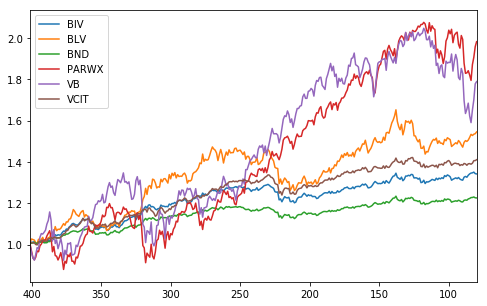

()


In [3]:

def graph_ret(dataframe, location):
	trn_ret_df = dataframe.sort_index(ascending=False)
	trn_ret_df.iloc[:,1:] = trn_ret_df.iloc[:,1:].add(1)
	for row in range(0,len(trn_ret_df.index), +1):
 		trn_ret_df.iloc[row,1:] = (trn_ret_df.iloc[row,1:]).mul(trn_ret_df.iloc[row-1,1:])
	trn_ret_df.plot(figsize=(8,5))
	plt.savefig(location)
	plt.show()
	return()

print(graph_ret(trn_df, "./return.png"))
plt.close()



In [4]:
noc=len(trn_df.columns)-1 # total number for index of columns
print("Number of Columns={}".format(noc))

Number of Columns=6


In [5]:
def basic_ret(dataframe, noc):# annualized mean return
	weights = np.random.random(noc) # initial random weights
	weights /= np.sum(weights) #take weight devide by sum of eights and save 
	
	exp_ret = np.dot(dataframe.mean(), weights) * mult #annualized expected return with initial weights
	exp_var = np.dot(weights.T, np.dot(dataframe.cov() * mult, weights))
	exp_vol = np.sqrt(exp_var)
	return(exp_var, exp_vol, exp_ret)

In [6]:
def simulation(dataframe, steps, noc):
	prets = []
	pvols = []
	for i in range(steps):
		weights = np.random.random(noc)
		weights /= np.sum(weights)
		exp_ret = np.dot(dataframe.mean(), weights) * mult
		prets.append(exp_ret)
		exp_var = np.dot(weights.T, np.dot(dataframe.cov() * mult, weights))
		pvols.append(np.sqrt(exp_var))
	prets = np.array(prets)
	pvols = np.array(pvols)
	return(prets, pvols)

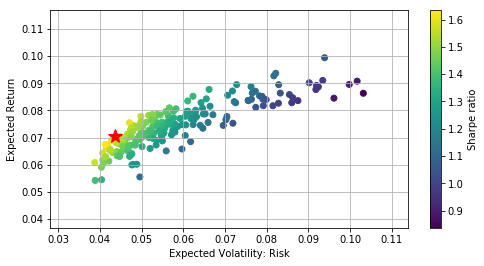

Please see the scatterplot.png


In [7]:
prets, pvols = simulation(trn_df,200,noc)[0:2]
exp_vol, exp_ret = basic_ret(trn_df, noc)[1:3]
plt.figure(figsize=(8,4))
plt.scatter(pvols,prets, c=prets / pvols, marker ="o")
plt.plot(exp_vol,exp_ret, 'r*', markersize=15.0)
plt.grid(True)
plt.xlabel("Expected Volatility: Risk")
plt.ylabel("Expected Return")
plt.colorbar(label = "Sharpe ratio")
plt.savefig("./scatterplot.png")
plt.show()
plt.close()
print("Please see the scatterplot.png")


In [8]:
def statistics(weights):
	weights = np.array(weights)
	pret = np.dot(trn_df.mean(), weights) * mult
	pvol = np.sqrt(np.dot(weights.T, np.dot(trn_df.cov() * mult, weights)))
	return(np.array([pret,pvol, pret / pvol]))
def min_sharpe(weights):
	return(-statistics(weights)[2])



In [9]:
base_weights = noc * [1/noc,]
print("baseweights ={}".format(base_weights))


baseweights =[0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]


In [10]:
cons = ({'type':'eq', 'fun':lambda x: np.sum(x) - 1}) #defining constraints 
bnds = tuple((0, 1) for x in range(noc))
blub = np.delete(np.array(trn_df.columns),(0), axis=0)
print(cons)
print(bnds)
print(blub)


{'type': 'eq', 'fun': <function <lambda> at 0x0000017234F0FD08>}
((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1))
['BIV' 'BLV' 'BND' 'PARWX' 'VB' 'VCIT']


In [11]:
opts = sco.minimize(min_sharpe, base_weights, method='SLSQP', bounds=bnds, constraints=cons)
max_sharp_weights = np.column_stack((blub, opts['x'].T.round(3)))
max_sharp_weights = np.flipud(max_sharp_weights[max_sharp_weights[:,1].argsort()])
print("Max Sharp weights")
print(max_sharp_weights)

Max Sharp weights
[['BIV' 0.436]
 ['BND' 0.333]
 ['PARWX' 0.188]
 ['BLV' 0.027]
 ['VCIT' 0.016]
 ['VB' 0.0]]


In [12]:
def min_variance(weights):
	return(statistics(weights)[1] ** 2)

In [13]:
optv = sco.minimize(min_variance, base_weights, method='SLSQP', bounds=bnds, constraints=cons)
min_var_weights = np.column_stack((blub, optv['x'].T.round(3)))
min_var_weights = np.flipud(min_var_weights[min_var_weights[:,1].argsort()])
print("Minimize risk weights")
print(min_var_weights)


Minimize risk weights
[['BND' 0.385]
 ['BIV' 0.278]
 ['VCIT' 0.223]
 ['PARWX' 0.114]
 ['VB' 0.0]
 ['BLV' 0.0]]


In [14]:
def min_pvol(weights):   #New function to minimize
	return(statistics(weights)[1])

In [15]:
optv = sco.minimize(min_pvol, base_weights, method='SLSQP', bounds=bnds, constraints=cons)
min_vol_weights = np.column_stack((blub, optv['x'].T.round(3)))
min_vol_weights = np.flipud(min_var_weights[min_var_weights[:,1].argsort()])
print("Minimize risk weights")
print(min_vol_weights)

Minimize risk weights
[['BND' 0.385]
 ['BIV' 0.278]
 ['VCIT' 0.223]
 ['PARWX' 0.114]
 ['BLV' 0.0]
 ['VB' 0.0]]


In [17]:
trets = np.linspace(0.05,0.11,10)
tvols = []
tweights = []

for tret in trets:
	cons = ({'type':'eq', 'fun':lambda x: statistics(x)[0] - tret},   #New constraints
			{'type':'eq', 'fun':lambda x: np.sum(x) - 1})
	res = sco.minimize(min_pvol, base_weights, method='SLSQP', bounds=bnds, constraints=cons)
	tvols.append(res['fun'])
	# temp2 = np.column_stack((res['fun'], res['x'].round(3)))
	# temp1 = np.column_stack(tret)
	
	# tweights.append(temp2)
	# # tweights.append(tret)
	# tweights.append(res['fun'])
	tweights.append(res['x'].round(3))
tvols = np.array(tvols)
tweights = np.array(tweights)
print(tweights)

front_line = np.column_stack((trets, tvols))
tweights = np.column_stack((front_line,tweights))
tweights = np.transpose(tweights)

dummy = ['return','volatility']
dummy = np.array(dummy)

print ("dummy dimmension = {}".format(dummy.shape))
blub = np.delete(np.array(trn_df.columns),(0), axis=0)
print ("blub = {}".format(blub))
dummy = np.append(dummy, blub)
# print ("dummy = {}".format(dummy))
# blub = np.concatenate((dummy,blub))

print ("blub = {}".format(blub))
tweights = np.column_stack((dummy,tweights))
print(tweights)

[[ 0.164  0.     0.675  0.158  0.     0.003]
 [ 0.265  0.036  0.446  0.182  0.     0.072]
 [ 0.508  0.082  0.198  0.213  0.     0.   ]
 [ 0.593  0.136  0.     0.241  0.     0.03 ]
 [ 0.256  0.257  0.     0.271  0.     0.216]
 [ 0.127  0.395  0.     0.321  0.     0.157]
 [ 0.013  0.534  0.     0.373  0.     0.08 ]
 [ 0.     0.523  0.     0.477  0.     0.   ]
 [ 0.     0.38   0.     0.62   0.     0.   ]
 [ 0.     0.238  0.     0.762  0.     0.   ]]
dummy dimmension = (2,)
blub = ['BIV' 'BLV' 'BND' 'PARWX' 'VB' 'VCIT']
blub = ['BIV' 'BLV' 'BND' 'PARWX' 'VB' 'VCIT']
[['return' 0.05 0.05666666666666667 0.06333333333333334 0.07
  0.07666666666666666 0.08333333333333334 0.09 0.09666666666666666
  0.10333333333333333 0.11]
 ['volatility' 0.030073686812617344 0.03393170206626638
  0.037933579602986885 0.04211442969493272 0.047089942648921836
  0.05255095499529489 0.05854816531079571 0.06703826318387368
  0.08546425059056736 0.10976295006336421]
 ['BIV' 0.164 0.265 0.508 0.593 0.256 0.127 0.013 

[[ 0.05        0.03007369]
 [ 0.05666667  0.0339317 ]
 [ 0.06333333  0.03793358]
 [ 0.07        0.04211443]
 [ 0.07666667  0.04708994]
 [ 0.08333333  0.05255095]
 [ 0.09        0.05854817]
 [ 0.09666667  0.06703826]
 [ 0.10333333  0.08546425]
 [ 0.11        0.10976295]]


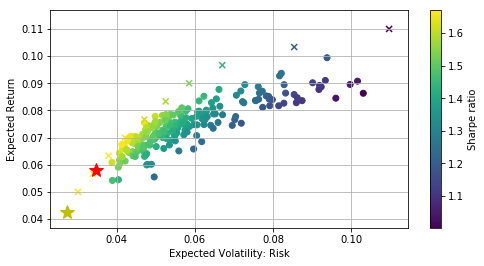

In [18]:
front_line = np.column_stack((trets, tvols))
print(front_line)

plt.figure(figsize=(8,4))
plt.scatter(pvols,prets, c=prets / pvols, marker ="o")
plt.scatter(tvols,trets, c=trets / tvols, marker ="x")
plt.plot(statistics(opts['x'])[1],statistics(opts['x'])[0], 'r*', markersize=15.0)
plt.plot(statistics(optv['x'])[1],statistics(optv['x'])[0], 'y*', markersize=15.0)
plt.grid(True)
plt.xlabel("Expected Volatility: Risk")
plt.ylabel("Expected Return")
plt.colorbar(label = "Sharpe ratio")
plt.savefig("./FrontierLine.png")
plt.show()
plt.close()
